# Generating an outline of the eFEDS region

Here we generate a figure for the eFEDS-XCS comparison paper. It shows the approximate outline of the eFEDS field, and any intersecting XMM pointings. We also calculate the approximate area of the eFEDS field that is covered by XMM observations.

## Import Statements

In [1]:
from astropy.io import fits
from astropy.visualization import LogStretch, ImageNormalize, MinMaxInterval
from astropy.units import Quantity
from astropy.convolution import convolve, Gaussian2DKernel
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

from xga.imagetools.profile import annular_mask
from xga import CENSUS

## Setup paths

This path is for my system, it won't be applicable to you if you wish to re-run this. The eFEDS data are [available here](https://erosita.mpe.mpg.de/edr/eROSITAObservations/CalPvObs/eFEDS.tar.gz), and are just the cleaned event lists:

In [2]:
efeds_path = "/home/dt237/archive/eFEDS/eFEDS/{n}.fits"

## Reading in files

Here we read in the eFEDS X-ray cluster candidate sample (Liu et al. 2021), which contains 542 X-ray selected cluster candidates - this file is [available](https://erosita.mpe.mpg.de/edr/eROSITAObservations/Catalogues/liuA/eFEDS_clusters_V3.fits.gz), but we have converted it to a csv for convenience. We also read in all four eFEDS event lists, which we will use to make an approximate outline.

In [3]:
efeds_sample = pd.read_csv("efeds_xray_cluster_candidates.csv")
efeds_sample.head(10)

,ID,ID_SRC,RA,DEC,EXT_LIKE,DET_LIKE,z,z_type,T_300kpc,T_300kpc_L,...,L_500kpc_L,L_500kpc_U,Lbol_500kpc,Lbol_500kpc_L,Lbol_500kpc_U,F_500kpc,F_500kpc_L,F_500kpc_U,SNR_MAX,R_SNR_MAX_ARCMIN
0,eFEDS J082626.6-003429,28993,126.610799,-0.574787,8.486203,5.029723,0.161110,0,-1.000000,-1.000000,...,-1.000000e+00,3.924900e+42,-1.000000e+00,-1.000000e+00,1.782000e+43,-1.000000e+00,-1.000000e+00,6.040400e-14,1.32,0.8011
1,eFEDS J082751.8-002853,11248,126.965471,-0.481638,12.791595,27.865910,0.257160,0,-1.000000,-1.000000,...,-1.000000e+00,1.061100e+43,-1.000000e+00,-1.000000e+00,1.796300e+43,-1.000000e+00,-1.000000e+00,4.903300e-14,3.07,0.7393
2,eFEDS J082808.8-001003,4800,127.036645,-0.167715,28.492811,62.512480,0.076155,0,0.885294,0.786329,...,2.339100e+42,3.424700e+42,4.402300e+42,3.640200e+42,5.339000e+42,1.976100e-13,1.624400e-13,2.382600e-13,8.78,2.6312
3,eFEDS J082820.6-000721,4169,127.085556,-0.122752,42.376125,81.378350,0.844900,0,-1.000000,-1.000000,...,1.890600e+44,2.762200e+44,6.207600e+44,5.089800e+44,8.013600e+44,7.796600e-14,6.555100e-14,8.961400e-14,7.30,1.4667
4,eFEDS J082840.6-000500,7991,127.169202,-0.083552,18.438711,37.515427,0.319705,0,-1.000000,-1.000000,...,1.419400e+43,2.065400e+43,3.993600e+43,3.175500e+43,4.931700e+43,5.510200e-14,4.443600e-14,6.466500e-14,5.61,1.3388
5,eFEDS J082900.0+010756,14973,127.249974,1.132314,19.179321,14.365816,0.354000,0,-1.000000,-1.000000,...,1.312900e+43,2.451900e+43,6.481100e+43,4.081500e+43,9.963200e+43,4.924400e-14,3.510200e-14,6.559700e-14,4.29,3.1570
6,eFEDS J082952.7+002140,7528,127.469684,0.361084,7.729656,38.626640,0.420000,0,-1.000000,-1.000000,...,1.067200e+43,1.842500e+43,3.816700e+43,2.719200e+43,5.480800e+43,2.461900e-14,1.860900e-14,3.194200e-14,4.61,0.6790
7,eFEDS J082955.5+004132,3810,127.480999,0.692199,24.177258,80.255554,0.939855,0,-1.000000,-1.000000,...,1.577300e+44,2.318200e+44,6.930800e+44,5.228000e+44,1.003800e+45,5.564200e-14,4.690000e-14,6.435100e-14,6.96,1.2089
8,eFEDS J083040.7+023220,9837,127.669739,2.538833,11.481833,23.703844,0.111320,0,-1.000000,-1.000000,...,4.930900e+41,1.044400e+42,1.166300e+42,7.767600e+41,1.637600e+42,2.241900e-14,1.482700e-14,3.137000e-14,3.29,0.7179
9,eFEDS J083110.6+015616,5601,127.794012,1.937839,11.771409,34.137924,0.419510,0,-1.000000,-1.000000,...,3.047600e+43,4.363200e+43,9.198500e+43,7.453000e+43,1.215700e+44,6.304600e-14,5.262900e-14,7.444600e-14,6.85,1.7166


In [4]:
efeds_0 = fits.open(efeds_path.format(n="fm00_300007_020_EventList_c001"))
efeds_1 = fits.open(efeds_path.format(n="fm00_300008_020_EventList_c001"))
efeds_2 = fits.open(efeds_path.format(n="fm00_300009_020_EventList_c001"))
efeds_3 = fits.open(efeds_path.format(n="fm00_300010_020_EventList_c001"))

## Concatenating all event positions

This is the beginning of the process that allows us to easily make an approximate outline of the eFEDS field. We've already read in all of the events in the eFEDS scan observations, but we only care about their positions, not any other information. As such, we combine the RA and DEC columns from the four files into two separate arrays:

In [5]:
all_ra = np.concatenate([efeds_0[1].data['RA'], efeds_1[1].data['RA'], efeds_2[1].data['RA'], 
                         efeds_3[1].data['RA']])
all_dec = np.concatenate([efeds_0[1].data['DEC'], efeds_1[1].data['DEC'], efeds_2[1].data['DEC'], 
                         efeds_3[1].data['DEC']])

We then close the currently open fits files:

In [6]:
efeds_0.close()
efeds_1.close()
efeds_2.close()
efeds_3.close()

## Identifying relevant XMM Observations

The XGA software package takes a census of available processed XMM observations (based on the directories given in its configuration file), and as XCS has processed the full XMM archive, we can use this census to identify ObsIDs which are within the general boundaries of the eFEDS field. Note that pointings in the irrelevant list have been excluded (by hand) because they do not actually intersect the eFEDS field, they just lie close enough that the approximate rectangular region picked them up:

In [7]:
# Cutting down the census of all XCS processed XMM observations to just those with a pointing within a 
#  rectangle defined using the min and max RA/Dec values of eFEDS events
xmm_sub_census = CENSUS[(CENSUS['RA_PNT'] > all_ra.min()) & (CENSUS['RA_PNT'] < all_ra.max()) & 
                        (CENSUS['DEC_PNT'] > all_dec.min()) & (CENSUS['DEC_PNT'] < all_dec.max())]

# ObsIDs that were removed by hand because they don't really intersect with the eFEDS field outline
#  It is a bit circular but considering this is just an illustrative figure thats fine
irrelevant_list = ['0762950301', '0655340141', '0655340157']

# Reading out the XMM pointing coordinates (RA and Dec) of the relevant observations, as well as their
#  XMM ObsIDs
xmm_pnt_ra = xmm_sub_census[~xmm_sub_census['ObsID'].isin(irrelevant_list)]['RA_PNT'].values
xmm_pnt_dec = xmm_sub_census[~xmm_sub_census['ObsID'].isin(irrelevant_list)]['DEC_PNT'].values
rel_obsid = xmm_sub_census[~xmm_sub_census['ObsID'].isin(irrelevant_list)]['ObsID'].values

We also save these to a file to allow access to anyone who doesn't wish to repeat this process:

In [8]:
# Storing the relevant columns in a new dataframe - could have just extracted this from xmm_sub_census
#  in retrospect, but I've already written this
xmm_obs_df = pd.DataFrame(data=np.array([rel_obsid, xmm_pnt_ra, xmm_pnt_dec]).T, 
                          columns=['ObsID', 'RA_PNT', 'DEC_PNT'])
# Saving this information as a csv
xmm_obs_df.to_csv("efeds_intersecting_xmm_obs.csv", index=False)

## Generating a basic image

We make a very coarsely binned image of the whole eFEDS field, using the positions that we read in from the event lists earlier, so that we can use it to find the approximate boundary of the field. We add a one degree boundary to the maximum and minimum RA and Dec values so that there is a gap around the edge of the field, this makes smoothing the image easier.

In [9]:
# Padding the RA and Dec limits by 1 degree
pad_val = 1
# Making an array of the padded maxima and minima
pad_range = [[all_dec.min()-pad_val, all_dec.max()+pad_val], [all_ra.min()-pad_val, all_ra.max()+pad_val]]
pad_range

[[-4.223283315519501, 7.099576083087285],
 [125.20363814596136, 146.82010938548257]]

We calculate the ratio of the side lengths of the bounding box we effectively declared in the cell above, this will be used to calculate an approximate number of bins for the y-axis to keep the resulting image in the correct aspect ratio. We set the number of bins on the x-axis to be 400, a relatively arbitrary number that we observe produces a relatively nice end result:

In [10]:
# We choose to have 400 bins on the x-axis
num_xbin = 400

# Calculate the approximate ratio of the side lengths of the field
side_ratio = (pad_range[1][1]-pad_range[1][0])/(pad_range[0][1]-pad_range[0][0])

# Use that ratio to scale the number of x-axis bins to find the number of y-axis bins
num_ybin = int(num_xbin/side_ratio)

Now we perform a 2D binning process to actually produce a 2D image:

In [11]:
# The first return from histogram2d contains count information, the other two contain position information
efeds_2d_binned, efeds_2d_posx, efeds_2d_posy, = np.histogram2d(all_dec, all_ra, range=pad_range, 
                                                                bins=[num_ybin, num_xbin])

Now we display that image, to check that the process has worked as intended:

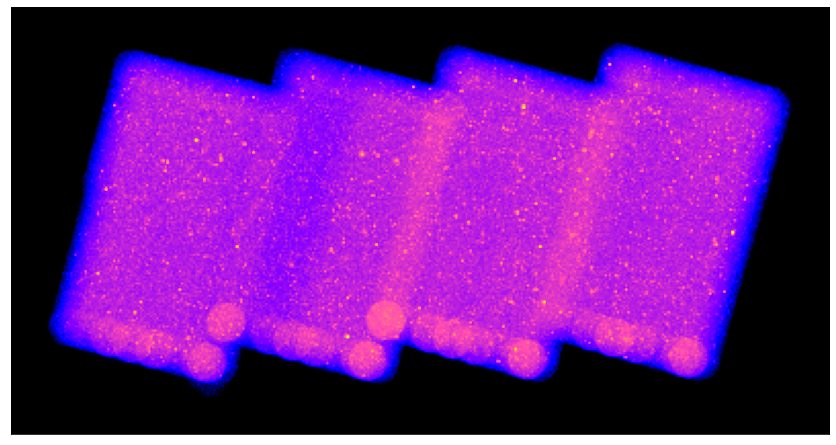

In [12]:
x_len = 12
y_len = x_len/side_ratio
plt.figure(figsize=(x_len, y_len))

norm = ImageNormalize(efeds_2d_binned, stretch=LogStretch(), interval=MinMaxInterval())
plt.imshow(efeds_2d_binned, norm=norm, origin='lower', cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Smoothing the image

Performing some basic smoothing on the image should improve the look of the outline that we derive from the eFEDs data. We simply use a Gaussian kernel taken from the Astropy convolution package, choosing a standard deviation of 0.5 pixels (again because we observe good final results): 

In [13]:
# Defining the smoothing scale of the Gaussian
std_dev = 0.5
# Running the smoothing process
efeds_smoothed = convolve(efeds_2d_binned, Gaussian2DKernel(std_dev, std_dev))

We again display an image to check that the smoothing has worked properly:

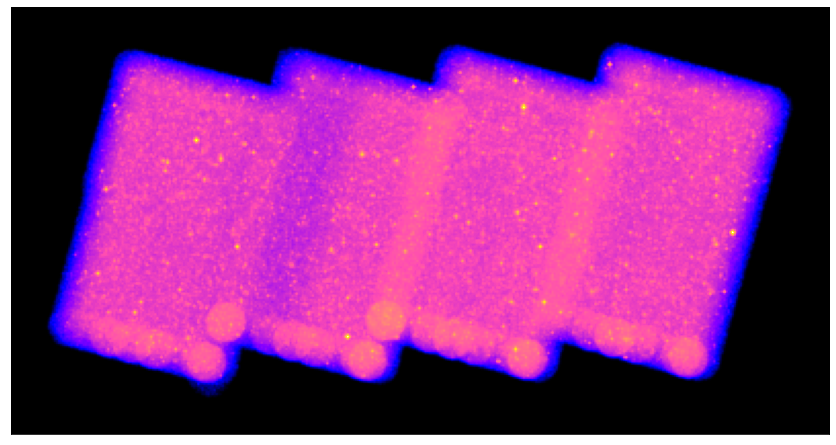

In [14]:
plt.figure(figsize=(x_len, y_len))

norm = ImageNormalize(efeds_smoothed, stretch=LogStretch(), interval=MinMaxInterval())
plt.imshow(efeds_smoothed, norm=norm, origin='lower', cmap='gnuplot2')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Generating an edge map of the eFEDS field

Here we turn the smoothed image into an approximate 'detector map', where the only values in the array are 1 (for on the 'detector') and 0 (for off the 'detector'). Then we can use a very simple edge finding algorithm to define the boundary of the field in such a way that we can plot it. This code is not very efficent (uses for loops and nested if statements), but as this process only really needed to be run once (and the image is not very high resolution), we decided that was acceptable. This process works much better on exposure maps, as they don't have any empty pixels within the field, but using the eFEDS event lists without extra processing was easier:

In [15]:
# Make a copy of the smoothed image to convert into a detector map
det_map = efeds_smoothed.copy()
# Any value that isn't a zero is now one
det_map[det_map != 0] = 1

# By tcalculating the difference between different rows, we can determine where we go onto and off of 
#  the detector, as these will be the only places where there is a different between the pixel values 
hori_edges = np.diff(det_map, axis=0, append=0)

# We have to correct the positions so they actually represent where the edge of the field is
need_corr_y, need_corr_x = np.where(hori_edges == 1)
new_y = need_corr_y + 1
hori_edges[need_corr_y, need_corr_x] = 0
hori_edges[new_y, need_corr_x] = 1
hori_edges[hori_edges == -1] = 1

# The same process is repeated along the other axis to find vertical edges
vert_edges = np.diff(det_map, axis=1, append=0)
need_corr_y, need_corr_x = np.where(vert_edges == 1)
new_x = need_corr_x + 1
vert_edges[need_corr_y, need_corr_x] = 0
vert_edges[need_corr_y, new_x] = 1
vert_edges[vert_edges == -1] = 1

# The two edge arrays are summed, which will mean that vertices of the outline may have a value 
#  of two, hence we set any pixel that doesn't have a value of one and doesn't have a value of zero, to one
comb = hori_edges + vert_edges
comb[(comb != 0) & (comb != 1)] = 1

# Make a copy, this is now the final edgemap
final_edgemap = comb.copy()

We view the edgemap to make sure it looks like we would expect:

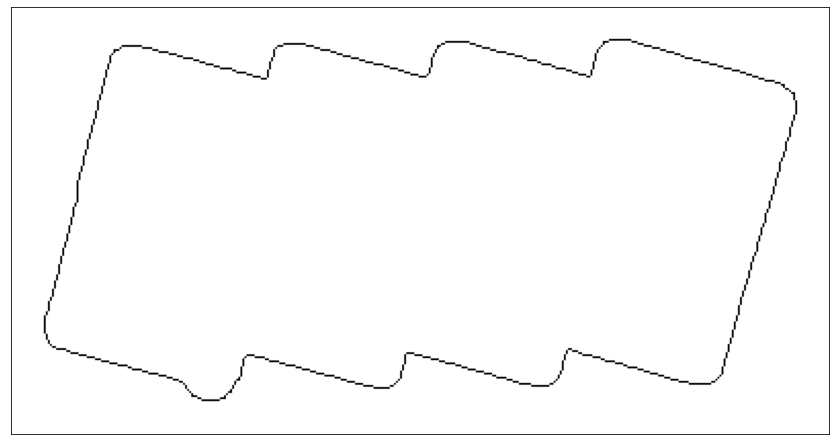

In [16]:
plt.figure(figsize=(x_len, y_len))

plt.imshow(final_edgemap, origin='lower', cmap='Greys')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Converting the edgemap to a set of coordinates

We have now created a 2D array that contains pixel values of 0 and 1, with one denoting where the edge of the eFEDS field is, however we wish to know the edge positions in RA and Dec so we can plot XMM observations along with it. We must also order the points so that we get a single solid boundary line, rather than having the line zigzagging between different boundary points:

In [17]:
# Locate pixels where the value is one, i.e. its on an edge of the eFEDS field
coord_pairs = np.where(comb == 1)
# Read out the RA and Dec boundaries of the pixels, this information is contained in the return of
#  the 2D binning process we ran earlier.
ra_bounds = efeds_2d_posy[coord_pairs[1]]
dec_bounds = efeds_2d_posx[coord_pairs[0]]

# Setup the final RA and Dec lists, and choose the first point in the list of edge points as 
#  somewhere to start.
final_ra = [ra_bounds[0]]
final_dec = [dec_bounds[0]]

# The process below selects the next nearest edge pixel to add to the list next, and as we do not
#  wish to consider pixels that have already been included, we maintain lists of the RAs and Decs that
#  haven't been used yet
working_ra = np.delete(ra_bounds, 0)
working_dec = np.delete(dec_bounds, 0)

# This very simply iterates through the set of edge positions, calculating the distances between the
#  last selected pixel and all other boundary pixels - then the next nearest pixel is selected and 
#  the process continues until we have an ordered set of eFEDS boundary RA and Dec pairs
with tqdm(desc='Ordering boundary points', total=len(ra_bounds)-1) as onwards: 
    while len(working_ra) != 0:
        distances = np.sqrt((final_ra[-1] - working_ra)**2 + (final_dec[-1] - working_dec)**2)
        chos_pnt = np.argmin(distances)
        final_ra.append(working_ra[chos_pnt])
        final_dec.append(working_dec[chos_pnt])
        working_ra = np.delete(working_ra, chos_pnt)
        working_dec = np.delete(working_dec, chos_pnt)
    
        onwards.update(1)

Ordering boundary points: 100%|██████████| 1002/1002 [00:00<00:00, 13988.97it/s]


## Generating the outline plot

We wish to create a figure that displays the outline of the eFEDs field, the eFEDS X-ray selected cluster candidates, and the XMM pointings that intersect with it. We have now gathered/generated all the information that we need to do just that:

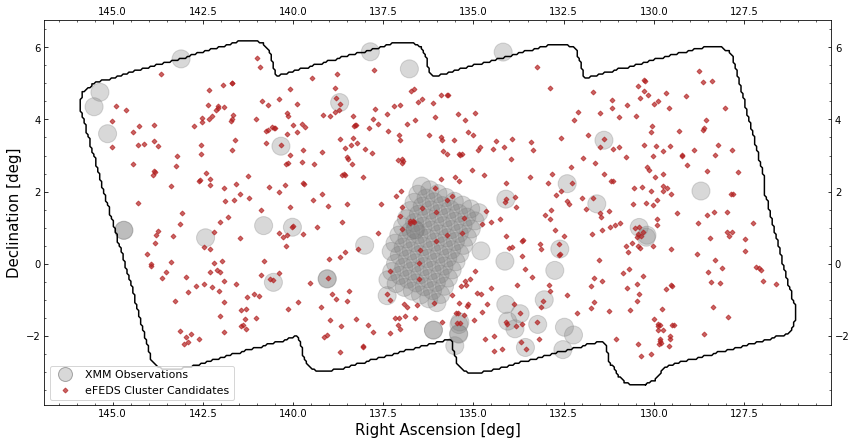

In [18]:
# Sets the x-axis size of the figure, then the y-axis size using the side ratio we calculated earlier
foot_xsize = 12
foot_ysize = foot_xsize/side_ratio

# Setup figure and the tick settings we want
plt.figure(figsize=(foot_xsize, foot_ysize))
ax = plt.gca()
ax.axis('equal')
plt.minorticks_on()
plt.tick_params(which='both', direction='in', top=True, right=True, labelright=True, labeltop=True)

# Plots the eFEDS field outline, making sure to add the starting position to the end of the 
#  RA and Dec lists to ensure that the outline is solid
plt.plot(final_ra+[final_ra[0]], final_dec+[final_dec[0]], color='black')

# Easily plot the X-ray selected eFEDS cluster candidates, taken from the sample file we read in earlier
efeds_obj = plt.plot(efeds_sample['RA'].values, efeds_sample['DEC'].values, 'D', color='firebrick', 
                     label='eFEDS Cluster Candidates', alpha=0.7, markersize=3.5)

# Cycle through the XMM ObsIDs that intersect with the eFEDS field, make a circular artist, and add
#  them to the plot axis.
for ra_ind, ra in enumerate(xmm_pnt_ra):
    dec = xmm_pnt_dec[ra_ind]
    # Create the artist with an approximate XMM field of view radius of 0.25 degrees (15 arcmin).
    #  Edges are left darker to illustrate the boundaries of individual observations in the central
    #  contiguous region
    artist = Circle([ra, dec], 0.25, fill=True, fc='tab:gray', ec='tab:gray', linewidth=1, 
                    linestyle='solid', alpha=0.3)
    ax.add_artist(artist)

# Makes another artist for us to use in the legend, as otherwise we wouldn't get the correct circle next
#  to XMM Observations
circle = Line2D([0], [0], color="black", marker='o', markerfacecolor="tab:gray", 
                label='XMM Observations', markersize=14, linewidth=0, alpha=0.3)

# This flips the x-axis to make the figure more in line with what is shown in the Liu et al eFEDS paper
xlims = ax.get_xlim()
ax.set_xlim(xlims[1], xlims[0])

# Set axis labels
plt.xlabel("Right Ascension [deg]", fontsize=15)
plt.ylabel("Declination [deg]", fontsize=15)

# Set position and contents of the legend
plt.legend(loc=3, fontsize=11., handles=[circle, efeds_obj[0]])
plt.tight_layout()
plt.savefig('output_figures/efeds_outline_xmm_pointings.pdf')
plt.show()

## Calculating an approximate eFEDS-XMM intersection area

As we know which XMM observations intersect with the eFEDS field, we can use an approximate XMM FoV radius of 0.25 degrees (15 arcminutes), as well as the pointing positions of the XMM observations, to create an array of ones and zeros (where ones represent being on an XMM pointing, and zeros represent being off of an XMM pointing).

We choose a set pixel scale of 5 arcseconds, then setup an array representing the padded boundaries of the eFEDS field - the pixels won't be *exactly* square because we do round to make the number of bins an integer, but we consider this to be acceptable for an approximate calculation). We can then use an existing XGA tool to generate masks for circular regions in this arbitrary space we've setup:

In [19]:
# Set the chosen pixel scale, and the approximate XMM FoV radius
pix_scale = Quantity(25, 'arcsec/pix')
xmm_fov_deg_rad = Quantity(0.25, 'deg')

# Calculate the number of pixels (of the chosen pixel scale), needed to represent the 
#  padded eFEDS boundaries - the pixels won't be exactly square because of the rounding
#  but we consider this acceptable considering this is approximate, and assuming a circular XMM FoV
#  probably has a greater overall effect
intersec_x_pix = (Quantity(np.diff(pad_range[1])[0], 'deg') / pix_scale).to('pix').round(0).astype(int)
intersec_y_pix = (Quantity(np.diff(pad_range[0])[0], 'deg') / pix_scale).to('pix').round(0).astype(int)

Set up the array here, so that it is reset if this cell is ever re-run.

The XGA tool we use here expects all information to be in pixels, so we have to convert the XMM observation's central RA and Dec coordinates to pixels, for the array that we just defined. This is not particularly difficult as we know the pixel scale, as well as various reference coordinates.

So we can cycle through our XMM observations, generating simple masks for all of them, and adding them to the overall intersection array:

In [20]:
intersec_arr = np.zeros((intersec_y_pix.value, intersec_x_pix.value))

xmm_fov_pix_rad = np.array([(xmm_fov_deg_rad/pix_scale).to('pix').value])

with tqdm(desc="Making masks of XMM observations", total=len(xmm_pnt_ra)) as onwards:
    for ra_ind, ra in enumerate(xmm_pnt_ra):
        dec = xmm_pnt_dec[ra_ind]
        x_pix = ((Quantity((ra - pad_range[1][0]), 'deg')/pix_scale).to('pix')).round(0)
        y_pix = ((Quantity((dec - pad_range[0][0]), 'deg')/pix_scale).to('pix')).round(0)
        central_coord = Quantity([x_pix, y_pix]).astype(int)

        temp_msk = annular_mask(central_coord, np.array([0]), xmm_fov_pix_rad, intersec_arr.shape)
        intersec_arr += temp_msk

        onwards.update(1)

Making masks of XMM observations: 100%|██████████| 143/143 [01:03<00:00,  2.26it/s]


Now we can look at the final array, containing masks for all XMM observations, to make sure it looks like we expect. This figure also illustrates that this array doesn't just contain binary values (which we would expect as we know a lot of the observations intersect). We also flip the x-axis to make it equivalent to the figure above:

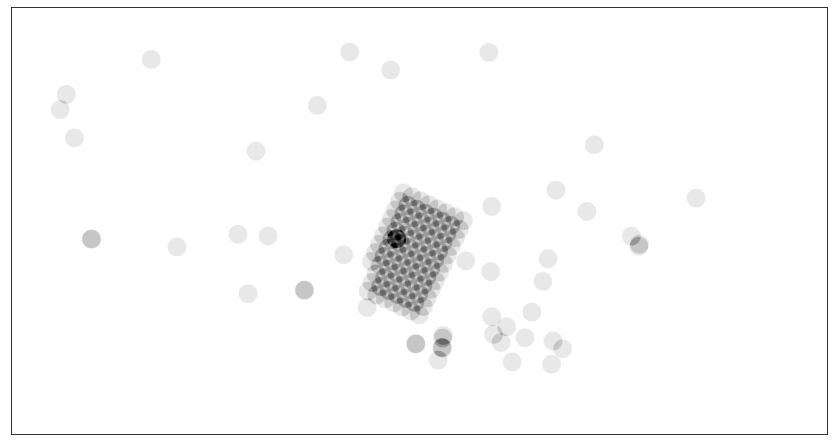

In [21]:
plt.figure(figsize=(x_len, y_len))
ax = plt.gca()

plt.imshow(intersec_arr, origin='lower', cmap='Greys')
plt.xticks([])
plt.yticks([])

xlims = ax.get_xlim()
ax.set_xlim(xlims[1], xlims[0])

plt.tight_layout()
plt.show()

Now we can change the intersection array so that the only values allowed are ones and zeros; ones meaning on an XMM pointing, zeros meaning off of an XMM pointing. That way we can just sum the array and get a total pixel area for the intersection between eFEDS and XMM. We also plot the array again to check it has worked:

In [22]:
xmm_intersec_map = intersec_arr.copy()
xmm_intersec_map[(xmm_intersec_map != 0) & (xmm_intersec_map != 1)] = 1

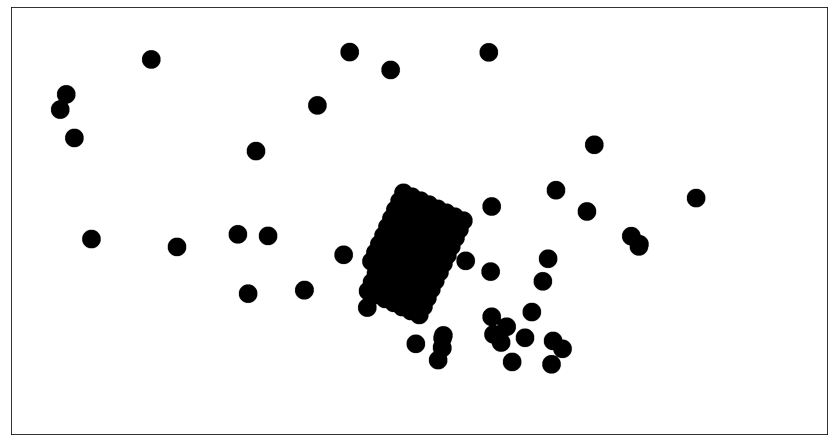

In [23]:
plt.figure(figsize=(x_len, y_len))
ax = plt.gca()

plt.imshow(xmm_intersec_map, origin='lower', cmap='Greys')
plt.xticks([])
plt.yticks([])

xlims = ax.get_xlim()
ax.set_xlim(xlims[1], xlims[0])

plt.tight_layout()
plt.show()

Now we can retrieve the intersection area in pix$^2$, and using our knowledge of the pixel scale, infer the intersection area in deg$^2$:

In [24]:
pix_area = Quantity(xmm_intersec_map.sum(), 'pix^2')

deg_area = (pix_area*(pix_scale**2)).to('deg^2')
deg_area

<Quantity 14.89342207 deg2>